In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torchvision import models
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
import timm

# DATASET

In [2]:
main_dir = "/content/drive/MyDrive/Trabalho-IA/"

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir(main_dir)
!ls

abobora-halloween  best_model2.pth  best_model.pth  controle-xbox


In [11]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset = datasets.ImageFolder(root=main_dir, transform=transform)

In [ ]:
image_dataset.classes

['abobora-halloween', 'controle-xbox']

In [ ]:
class Data(Dataset):
    def __init__(self, dir, transform=None):
        self.dir = dir
        self.transform = transform
        self.classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.instances = self.make_instances()

    def make_instances(self):
        instances = []
        for class_name in self.classes:
            class_dir = os.path.join(self.dir, class_name)
            for root, _, fnames in os.walk(class_dir):
                for fname in fnames:
                    path = os.path.join(root, fname)
                    item = path, self.class_to_idx[class_name]
                    instances.append(item)
        return instances

    def __getitem__(self, index):
        path, target = self.instances[index]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.instances)

# LOADER

In [5]:
def image_loader(img):
    return Image.open(img).convert("RGB")

In [6]:
img = image_loader('./controle-xbox/20241027_100645.jpg')

In [7]:
tconvert = transforms.Resize((255,255))

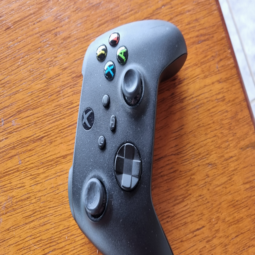

In [8]:
tconvert(img)

In [9]:
tconvert2 =  transforms.CenterCrop((227,227))

In [12]:
img_tensor = transform(img)

# Treinamento model efficientnet_b0.ra_in1k

> Adicionar aspas



In [13]:
ds = image_dataset

In [14]:
ds.targets = np.array(ds.targets)

In [15]:
bs = 64
train_idx, temp_idx = train_test_split(np.arange(len(ds)),test_size=0.3,shuffle=True,stratify=ds.targets)
valid_idx, test_idx = train_test_split(temp_idx,test_size=0.5,shuffle=True,stratify=ds.targets[temp_idx])

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler  = torch.utils.data.SubsetRandomSampler(test_idx)

dl_train = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=train_sampler)
dl_valid = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=valid_sampler)
dl_test  = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=test_sampler)

In [16]:
x,y = next(iter(dl_train))

In [17]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
model = timm.create_model('efficientnet_b0.ra_in1k', pretrained=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [19]:
#model = timm.create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [20]:
loss_train = []
loss_eval  = []

patience_time = 15
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(),lr=0.01)

In [ ]:
epochs = 10

stop = False
epoch = 0
lowest_loss_eval = 10000
last_best_result = 0
while (not stop):
    #wandb.watch(model)
    model.train()
    lloss = []
    for x,y in dl_train:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        closs = criterion(pred,y)
        closs.backward()
        opt.step()
        opt.zero_grad()
        lloss.append(closs.item())
        #print(closs.item())
    loss_train.append(np.mean(lloss))
    lloss = []
    model.eval()
    lres = []
    ytrue = []
    with torch.no_grad():
        for data,y in dl_valid:
            data = data.to(device)

            pred = model(data)
            closs = criterion(pred.cpu(),y)
            lloss.append(closs.item())
            res  = pred.argmax(dim=1).cpu().tolist()
            lres += res
            ytrue += y
    avg_loss_eval = np.mean(lloss)
    loss_eval.append(avg_loss_eval)
    #wandb.log({"loss_eval": avg_loss_eval,"loss_train":loss_train[-1]})
    if avg_loss_eval < lowest_loss_eval:
        lowest_loss_eval = avg_loss_eval
        last_best_result = 0
        print("Best model found! saving...")
        actual_state = {'optim':opt.state_dict(),'model':model.state_dict(),'epoch':epoch,'loss_train':loss_train,'loss_eval':loss_eval}
        #torch.save(model.state_dict(), 'best_model.pth')
        torch.save(actual_state,'best_model.pth')
    last_best_result += 1
    if last_best_result > patience_time:
        stop = True
    print("epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"%(epoch,loss_train[-1],loss_eval[-1],last_best_result))
    epoch += 1

In [21]:
model_path = '/content/drive/MyDrive/Trabalho-IA/best_model.pth'
recover = torch.load(model_path, map_location=torch.device('cpu'))

#actual_state = {'optim':opt.state_dict(),'model':model.state_dict(),'epoch':epoch}

opt.load_state_dict(recover['optim'])
model.load_state_dict(recover['model'], strict=False)
loss_train = recover['loss_train']
loss_eval = recover['loss_eval']
epoch = recover['epoch']

<ipython-input-21-9c32bdd3ed16>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recover = torch.load(model_path, map_location=torch.device('cpu'))


In [22]:
l = []
for layer in model.children():
    l.append(layer)

In [23]:
model.head = nn.Linear(1024,1)

In [24]:
model.eval()
lres = []
ytrue = []
with torch.no_grad():
    for data,target in dl_test:
        data = data.to(device)
        pred = model(data)
        res  = pred.argmax(dim=1).cpu().tolist()
        lres += res
        ytrue += target

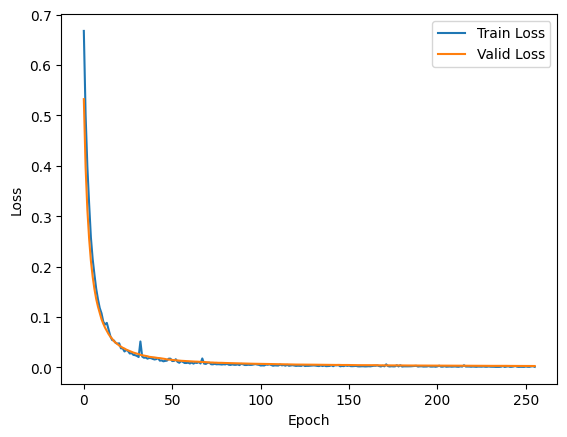

In [25]:
plt.plot(loss_train, label='Train Loss')
plt.plot(loss_eval, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import classification_report

# Gera o relatório de classificação
print(classification_report(ytrue, lres, target_names=["abobora-halloween", "controle-xbox"]))

                   precision    recall  f1-score   support

abobora-halloween       1.00      1.00      1.00        33
    controle-xbox       1.00      1.00      1.00        31

         accuracy                           1.00        64
        macro avg       1.00      1.00      1.00        64
     weighted avg       1.00      1.00      1.00        64



# Treinamento model  Mobilenetv3

---



> Adicionar aspas



In [27]:
ds = image_dataset

In [28]:
ds.targets = np.array(ds.targets)

In [29]:
bs = 64
train_idx, temp_idx = train_test_split(np.arange(len(ds)),test_size=0.3,shuffle=True,stratify=ds.targets)
valid_idx, test_idx = train_test_split(temp_idx,test_size=0.5,shuffle=True,stratify=ds.targets[temp_idx])

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler  = torch.utils.data.SubsetRandomSampler(test_idx)

dl_train = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=train_sampler)
dl_valid = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=valid_sampler)
dl_test  = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=test_sampler)

In [30]:
x,y = next(iter(dl_train))

In [31]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#print(timm.list_models('*mobile*'))

['mobilenet_edgetpu_100', 'mobilenet_edgetpu_v2_l', 'mobilenet_edgetpu_v2_m', 'mobilenet_edgetpu_v2_s', 'mobilenet_edgetpu_v2_xs', 'mobilenetv1_100', 'mobilenetv1_100h', 'mobilenetv1_125', 'mobilenetv2_035', 'mobilenetv2_050', 'mobilenetv2_075', 'mobilenetv2_100', 'mobilenetv2_110d', 'mobilenetv2_120d', 'mobilenetv2_140', 'mobilenetv3_large_075', 'mobilenetv3_large_100', 'mobilenetv3_large_150d', 'mobilenetv3_rw', 'mobilenetv3_small_050', 'mobilenetv3_small_075', 'mobilenetv3_small_100', 'mobilenetv4_conv_aa_large', 'mobilenetv4_conv_aa_medium', 'mobilenetv4_conv_blur_medium', 'mobilenetv4_conv_large', 'mobilenetv4_conv_medium', 'mobilenetv4_conv_small', 'mobilenetv4_conv_small_035', 'mobilenetv4_conv_small_050', 'mobilenetv4_hybrid_large', 'mobilenetv4_hybrid_large_075', 'mobilenetv4_hybrid_medium', 'mobilenetv4_hybrid_medium_075', 'mobileone_s0', 'mobileone_s1', 'mobileone_s2', 'mobileone_s3', 'mobileone_s4', 'mobilevit_s', 'mobilevit_xs', 'mobilevit_xxs', 'mobilevitv2_050', 'mobilev

In [32]:
model2 = timm.create_model('mobilenetv3_small_100', pretrained=True)

model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

In [33]:
#model2 = timm.create_model('mobilenetv3_small_050', pretrained=True)
model2.classifier = nn.Linear(1024, 2)
model2.to(device)

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): ReLU(inplace=True)
          (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (gate): Hardsigmoid()
        )
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): B

In [34]:
loss_train2 = []
loss_eval2  = []

patience_time = 15
criterion2 = nn.CrossEntropyLoss()
opt2 = optim.SGD(model2.parameters(),lr=0.01)

In [ ]:
epochs = 10

stop = False
epoch = 0
lowest_loss_eval = 10000
last_best_result = 0
while (not stop):
    #wandb.watch(model)
    model2.train()
    lloss = []
    for x,y in dl_train:
        x = x.to(device)
        y = y.to(device)
        pred2 = model2(x)
        closs = criterion2(pred2,y)
        closs.backward()
        opt2.step()
        opt2.zero_grad()
        lloss.append(closs.item())
        #print(closs.item())
    loss_train2.append(np.mean(lloss))
    lloss = []
    model2.eval()
    lres2 = []
    ytrue2 = []
    with torch.no_grad():
        for data,y in dl_valid:
            data = data.to(device)

            pred2 = model2(data)
            closs = criterion2(pred2.cpu(),y)
            lloss.append(closs.item())
            res  = pred2.argmax(dim=1).cpu().tolist()
            lres2 += res
            ytrue2 += y
    avg_loss_eval = np.mean(lloss)
    loss_eval2.append(avg_loss_eval)
    #wandb.log({"loss_eval": avg_loss_eval,"loss_train":loss_train[-1]})
    if avg_loss_eval < lowest_loss_eval:
        lowest_loss_eval = avg_loss_eval
        last_best_result = 0
        print("Best model found! saving...")
        actual_state2 = {'optim':opt2.state_dict(),'model':model2.state_dict(),'epoch':epoch,'loss_train':loss_train2,'loss_eval':loss_eval2}
        torch.save(actual_state2,'best_model2.pth')
    last_best_result += 1
    if last_best_result > patience_time:
        stop = True
    print("epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"%(epoch,loss_train2[-1],loss_eval2[-1],last_best_result))
    epoch += 1

In [35]:
model_path = '/content/drive/MyDrive/Trabalho-IA/best_model2.pth'
recover = torch.load(model_path, map_location=torch.device('cpu'))

opt2.load_state_dict(recover['optim'])
model2.load_state_dict(recover['model'], strict=False)
loss_train2 = recover['loss_train']
loss_eval2 = recover['loss_eval']
epoch = recover['epoch']

<ipython-input-35-db15d7be4438>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recover = torch.load(model_path, map_location=torch.device('cpu'))


In [36]:
l = []
for layer in model2.children():
    l.append(layer)

In [37]:
model2.head = nn.Linear(1024,1)

In [38]:
model2.eval()
lres2 = []
ytrue2 = []
with torch.no_grad():
    for data,target in dl_test:
        data = data.to(device)
        pred = model2(data)
        res  = pred.argmax(dim=1).cpu().tolist()
        lres2 += res
        ytrue2 += target

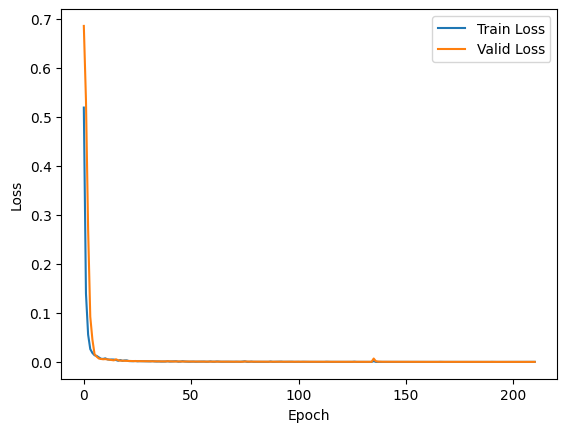

In [39]:
plt.plot(loss_train2, label='Train Loss')
plt.plot(loss_eval2, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import classification_report

# Gera o relatório de classificação
print(classification_report(ytrue2, lres2, target_names=["abobora-halloween", "controle-xbox"]))

                   precision    recall  f1-score   support

abobora-halloween       1.00      1.00      1.00        33
    controle-xbox       1.00      1.00      1.00        31

         accuracy                           1.00        64
        macro avg       1.00      1.00      1.00        64
     weighted avg       1.00      1.00      1.00        64



# Validação Imagens


In [41]:
from PIL import Image

In [42]:
def image_loader(img):
    return Image.open(img).convert("RGB")

In [43]:
img = image_loader('./controle-xbox/20241027_100651.jpg')


In [44]:
x = transform(img)
x.shape
#x = x.view(1,3,50,50)
x.shape
x = x.unsqueeze(0)
x = x.to(device)


In [45]:
x

tensor([[[[ 0.8447,  0.9474,  0.7591,  ...,  0.7419,  0.9646,  1.1015],
          [ 0.8104,  0.9646,  0.7419,  ...,  0.9817,  1.0502,  1.1358],
          [ 0.7933,  0.9132,  0.8276,  ...,  1.0331,  1.1015,  1.1015],
          ...,
          [ 0.7077,  0.6906,  0.9132,  ...,  1.1015,  0.8789,  1.0673],
          [ 0.5707,  0.7419,  0.8961,  ...,  0.7077,  1.0331,  1.1700],
          [ 0.4337,  0.7933,  0.8789,  ...,  0.7933,  1.1358,  1.0673]],

         [[ 0.4853,  0.5028,  0.2577,  ..., -0.3375, -0.1450, -0.0049],
          [ 0.5203,  0.5028,  0.2402,  ..., -0.0924, -0.0399,  0.0301],
          [ 0.5728,  0.4503,  0.2927,  ..., -0.0574,  0.0126,  0.0126],
          ...,
          [-0.1975, -0.2150, -0.0049,  ...,  0.0651, -0.2150, -0.0399],
          [-0.3200, -0.1625, -0.0399,  ..., -0.3200, -0.0399,  0.0651],
          [-0.4076, -0.1099, -0.0574,  ..., -0.2325,  0.0476, -0.0399]],

         [[ 0.8099,  0.8274,  0.5834,  ..., -0.8807, -0.7761, -0.6541],
          [ 0.9494,  0.7925,  

In [46]:
pred = model(x)

In [47]:
pred2 = model2(x)

In [48]:
pred

tensor([[-3.9544,  4.0938]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [49]:
pred2

tensor([[-3.8648,  3.8459]], device='cuda:0', grad_fn=<AddmmBackward0>)